In [ ]:
import os, re, numpy as np, pandas as pd
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


from collections import Counter
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
from torch.nn import BCELoss
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1) CONFIG
DRIVE_PATH    = '/content/drive/MyDrive/AML/Reddit Sarcasm/'
TRAIN_CSV     = os.path.join(DRIVE_PATH, 'train-balanced-sarcasm.csv')
GLOVE_PATH    = os.path.join(DRIVE_PATH, 'glove.6B.100d.txt')
MAX_VOCAB     = 10000
MAX_LEN       = 150
EMBED_DIM     = 100
HIDDEN_SIZE   = 128
BATCH_SIZE    = 128
EPOCHS        = 10
DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 2) LOAD & CLEAN
df = pd.read_csv(TRAIN_CSV)

df.isnull()             # Returns a DataFrame of True/False for missing cells
df.isnull().sum()       # Counts missing values per column
df['label'].value_counts(normalize=True) * 100

df = df[['label', 'parent_comment']].dropna()

df['comment_clean'] = (df['parent_comment']
                       .astype(str)
                       .str.lower()
                       .str.replace(r'[^\w\s]', '', regex=True))

df.groupby('label').sample(n=10, random_state=42) #to see sample of data

,label,parent_comment,comment_clean
772932,0,I love Sanders people. When 60% say wealth dis...,i love sanders people when 60 say wealth distr...
445608,0,Pawsitively relaxed,pawsitively relaxed
354910,0,Probably skiddies that are too afraid/unskille...,probably skiddies that are too afraidunskilled...
284811,0,"huge geography freak here as well, SO many maj...",huge geography freak here as well so many majo...
516997,0,Hearthstone? That's not an actually competitiv...,hearthstone thats not an actually competitive ...
351892,0,where is this pic from? is that a screenshot f...,where is this pic from is that a screenshot fr...
264439,0,"No she wouldn't. She would however, write a bo...",no she wouldnt she would however write a book ...
55807,0,That's going to be expensive to get into !,thats going to be expensive to get into
225459,0,"something something tax, death and ..",something something tax death and
690970,0,Does anyone know why this happens? This is the...,does anyone know why this happens this is the ...


label
1    500689
0    500043
Name: count, dtype: int64
       char_count                             word_count                    \
             mean median         std min  max       mean median        std   
label                                                                        
0      116.813748   71.0  132.137025   1  951  21.416590   13.0  24.322354   
1      119.211884   76.0  127.139853   1  951  21.569809   14.0  23.226552   

                
      min  max  
label           
0       0  198  
1       0  199  


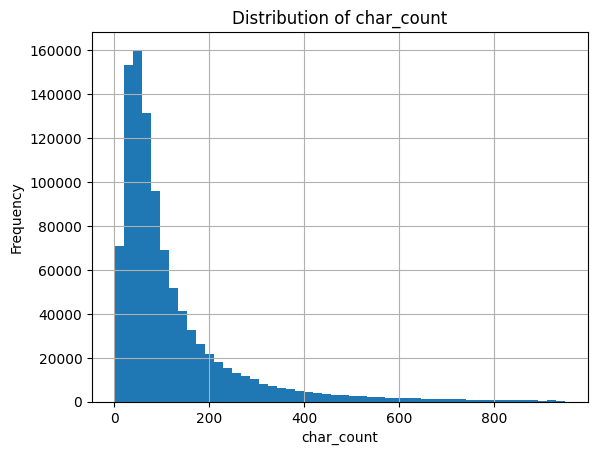

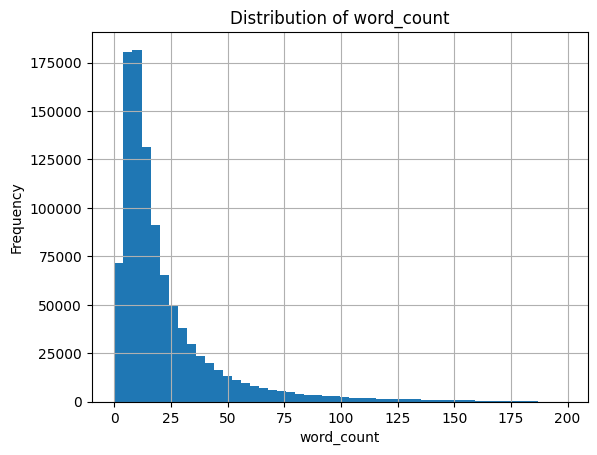

<Figure size 640x480 with 0 Axes>

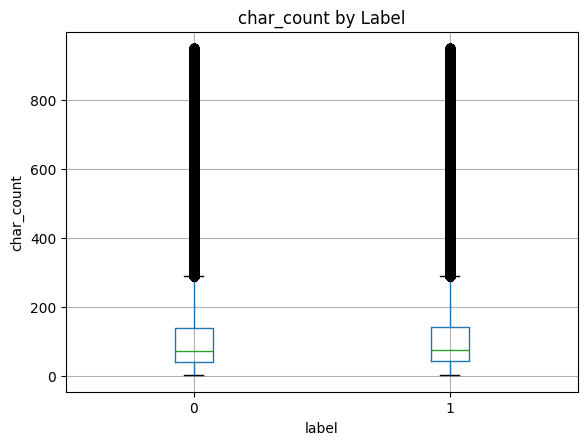

<Figure size 640x480 with 0 Axes>

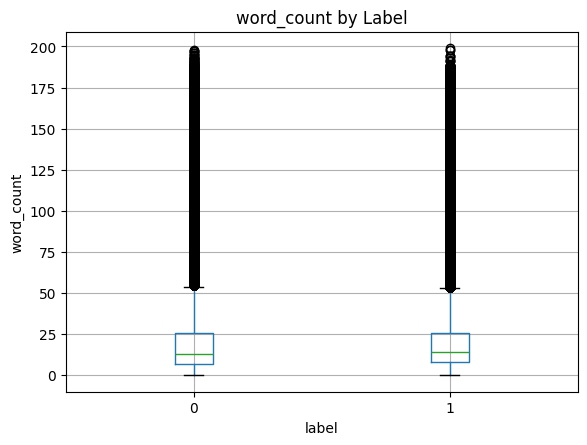

Top 20 words (all): [('the', 820290), ('to', 545812), ('a', 526783), ('i', 415283), ('and', 413420), ('of', 351643), ('is', 309275), ('in', 284523), ('you', 268344), ('that', 264352), ('it', 258615), ('for', 209997), ('this', 167257), ('on', 160431), ('be', 141531), ('have', 136588), ('with', 136179), ('are', 133042), ('not', 127142), ('but', 125612)]
Top 20 words (label=0): [('the', 410357), ('to', 268828), ('a', 263963), ('i', 228253), ('and', 205336), ('of', 170914), ('is', 151929), ('you', 141222), ('in', 139402), ('it', 136041), ('that', 129090), ('for', 105569), ('on', 81372), ('this', 80722), ('be', 70094), ('have', 69355), ('with', 68701), ('but', 67191), ('my', 63115), ('are', 63056)]
Top 20 words (label=1): [('the', 409933), ('to', 276984), ('a', 262820), ('and', 208084), ('i', 187030), ('of', 180729), ('is', 157346), ('in', 145121), ('that', 135262), ('you', 127122), ('it', 122574), ('for', 104428), ('this', 86535), ('on', 79059), ('be', 71437), ('are', 69986), ('with', 6747

In [ ]:
# 3) EDA
# Assume df has: ['label', 'parent_comment', 'comment_clean']

# Add length features
df['char_count'] = df['parent_comment'].str.len()
df['word_count'] = df['comment_clean'].str.split().str.len()
cap = df['char_count'].quantile(0.99)
df = df[df['char_count'] <= cap]

# Label distribution
print(df['label'].value_counts(dropna=False))

# Descriptive stats of lengths by label
print(df.groupby('label')[['char_count','word_count']].agg(['mean','median','std','min','max']))

# Histograms of lengths
for col in ['char_count','word_count']:
    plt.figure()
    df[col].hist(bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Compare length distributions by label (boxplots)
for col in ['char_count','word_count']:
    plt.figure()
    df.boxplot(column=col, by='label')
    plt.title(f'{col} by Label')
    plt.suptitle('')
    plt.xlabel('label')
    plt.ylabel(col)
    plt.show()

# Top-N most common words overall
all_words = ' '.join(df['comment_clean']).split()
top_all = Counter(all_words).most_common(20)
print("Top 20 words (all):", top_all)

# 7. Top-N words per label
for lbl in df['label'].unique():
    words = ' '.join(df.loc[df['label']==lbl, 'comment_clean']).split()
    top_lbl = Counter(words).most_common(20)
    print(f"Top 20 words (label={lbl}):", top_lbl)

# 1. Build stop-word set
stopwords = set(ENGLISH_STOP_WORDS)

# 2. Flatten and filter all words
words = [
    w
    for text in df['comment_clean'].dropna()
    for w in text.split()
    if w not in stopwords
]

# 3. Count and take top 20
common = Counter(words).most_common(20)
df_common = pd.DataFrame(common, columns=['word', 'frequency'])

print(df_common)


What this really shows is that the “Top 20” is almost entirely made up of English stop-words — “the,” “to,” “a,” “and,” etc.— which dominate any raw frequency list. As-is, these lists tell more about the underlying language than about sarcasm. A few tiny class-specific nudges do peek through:

Label 0 has “my” in the top 20
Label 1 has “not” and “they” in the top 20

—but the signal there is drowned by the noise of “the,” “to,” “and,” etc.



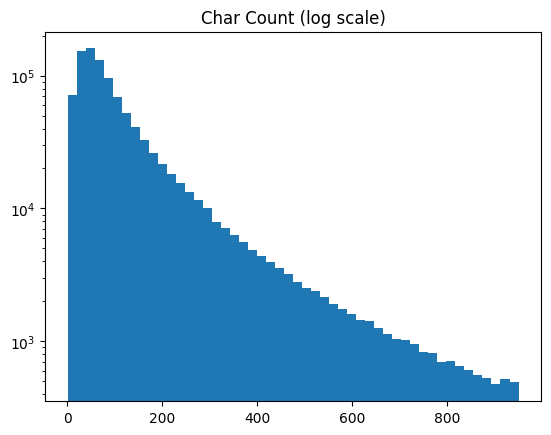

      word  frequency
0     just     108870
1     like      99981
2   people      78918
3     dont      76099
4       im      70108
5    think      53789
6     know      45642
7     time      41813
8   really      41314
9     game      39938
10    good      37695
11    make      33222
12    want      32354
13   thats      32118
14     new      29097
15   going      28660
16     way      27992
17   right      27865
18     got      27385
19     did      27244


In [ ]:
plt.hist(df['char_count'], bins=50, log=True)
plt.title('Char Count (log scale)')
plt.show()

# 1. Build stop-word set
stopwords = set(ENGLISH_STOP_WORDS)

# 2. Flatten and filter all words
words = [
    w
    for text in df['comment_clean'].dropna()
    for w in text.split()
    if w not in stopwords
]

# 3. Count and take top 20
common = Counter(words).most_common(20)
df_common = pd.DataFrame(common, columns=['word', 'frequency'])

print(df_common)


| Rank | Word   | Freq    | Why it matters                                                    |
| ---- | ------ | ------- | ----------------------------------------------------------------- |
| 1    | just   | 108,870 | “Just” often crops up in sarcastic hedges (“Just what I needed”). |
| 2    | like   | 99,981  | Filler or comparative (“it’s like…”), can signal mockery.         |
| 3    | people | 78,918  | Generic, but watch phrases (“people who…”) for sarcastic targets. |
| 4    | dont   | 76,099  | Negation—sarcasm loves “don’t” (“Don’t you love it when…”).       |
| 5    | im     | 70,108  | First-person marker; sarcasm is often personal.                   |
| …    | …      | …       | …                                                                 |
| 8    | time   | 41,813  | Timing words (“next time”), can frame irony.                      |
| 9    | really | 41,314  | Intensifier—“really great” vs. “really great?”                    |
| 17   | right  | 27,865  | Rhetorical “right?” is a classic sarcasm cue.                     |
| 19   | got    | 27,385  | “Got to love…” is often dripping with irony.                      |

Takeaways

We’re surfacing the kinds of hedges, intensifiers, and negations that sarcasm leans on.
It’s still pretty generic—words like “just,” “like,” and “really” appear in all Reddit.

In [ ]:
vec = CountVectorizer(
    ngram_range=(2,3),
    stop_words='english',
    min_df=1000  # only n-grams in ≥1000 docs
)
X = vec.fit_transform(df['comment_clean'])
freqs = np.asarray(X.sum(axis=0)).ravel()
ngrams = vec.get_feature_names_out()
top_idx = freqs.argsort()[::-1][:50]
for idx in top_idx:
    print(f"{ngrams[idx]}: {freqs[idx]}")


dont know: 8667
dont think: 6403
im sure: 5343
looks like: 4820
dont want: 4482
feel like: 4432
ive seen: 3485
year old: 3074
years ago: 2960
dont like: 2877
just like: 2861
dont understand: 2780
im going: 2705
sounds like: 2638
look like: 2618
people dont: 2604
pretty sure: 2587
im just: 2564
just dont: 2312
im pretty: 2084
donald trump: 1914
dont need: 1875
just got: 1864
high school: 1828
dont care: 1819
people like: 1781
doesnt mean: 1738
people think: 1719
make sure: 1713
lot people: 1652
just want: 1649
dont really: 1621
people just: 1596
makes sense: 1590
id like: 1584
didnt know: 1574
im pretty sure: 1569
ive heard: 1496
long time: 1490
things like: 1443
white people: 1408
hillary clinton: 1369
doesnt make: 1338
new york: 1294
really good: 1287
im sorry: 1263
united states: 1250
make sense: 1250
holy shit: 1241
im looking: 1240


These bigram hits are exactly the kind of hedging and framing phrases that carry sarcastic weight.

Negation + hedge
“dont know,” “dont think,” “dont want,” “dont like,” “dont understand”
These constructions often signal mock disbelief or rhetorical distancing—classic sarcasm territory.

Pseudo-certainty phrases
“im sure,” “pretty sure,” “im pretty,” “im just”
Over-stated confidence can be dripping with irony: “I’m sure this is a fantastic idea.”

Comparisons & similes
“looks like,” “feel like,” “sounds like,” “look like,” “just like”
They set up expectations only to undercut them, e.g. “Oh, it looks like we have another genius in the room.”

Personal observations
“ive seen,” “year old,” “years ago,” “people dont”
These can prefix stories that end in a sarcastic punchline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading GloVe


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train: 0.6739, 0.5807 |  Val:   0.6682, 0.5918
Epoch 2/10 | Train: 0.6639, 0.5998 |  Val:   0.6672, 0.5931
⏹ Early stopping at epoch 3
Best Val Loss: 0.6672, Val Acc: 0.5928


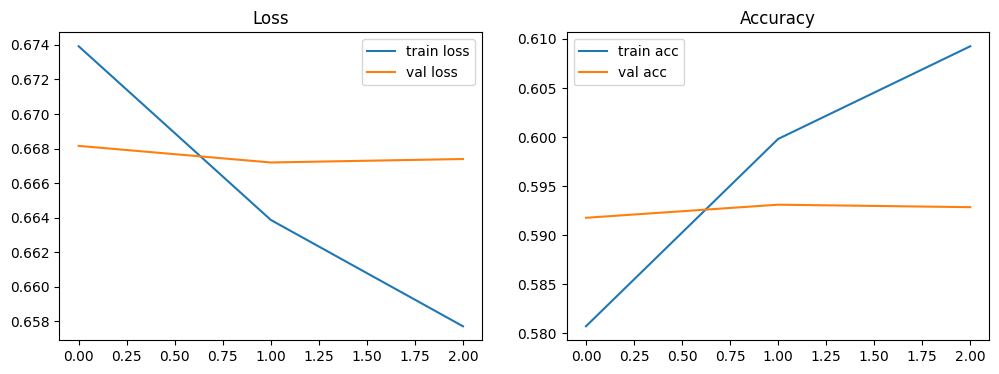

In [ ]:
#model building

#imports
import os, re, numpy as np, pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

#PHRASE MERGING - TOP 20
phrases = [
    'dont know','dont think','im sure','looks like','dont want',
    'feel like','ive seen','year old','years ago','dont like',
    'just like','dont understand','im going','sounds like',
    'look like','people dont','pretty sure','im just','just dont',
    'im pretty',

    #additional words for tweaking:
    #'donald trump',
    #'just got',
    #'dont need',
    #'high school',
    #'dont care',
    #'people like',
    #'doesnt mean',
    #'people think',
    #'make sure',
    #'just want',
    #'im pretty sure',
    #'people just',
    #'dont really',
    #'lot people',
    #'makes sense',
    #'didnt know',
    #'id like',
    #'ive heard',
    #'long time','white people',
    #'hillary clinton','things like','doesnt make','new york','united states',
    #'holy shit','im sorry','really good','does mean','make sense'
]
def merge_phrases(text):
    for phr in phrases:
        text = re.sub(rf'\b{re.escape(phr)}\b',
                      phr.replace(' ', '_'),
                      text)
    return text

df['comment_merged'] = df['comment_clean'].apply(merge_phrases)

# BUILD VOCAB
all_tokens = [tok
    for txt in df['comment_merged']
    for tok in txt.split()
]
cnt = Counter(all_tokens)
most_common = cnt.most_common(MAX_VOCAB - 2)
word2idx = {w: i+2 for i, (w,_) in enumerate(most_common)}
word2idx['<PAD>'], word2idx['<OOV>'] = 0, 1

# TEXT→SEQS & PAD
def tokenize_and_pad(texts):
    seqs = []
    for txt in texts:
        idxs = [word2idx.get(tok,1) for tok in txt.split()]
        if len(idxs) < MAX_LEN:
            idxs += [0]*(MAX_LEN-len(idxs))
        else:
            idxs = idxs[:MAX_LEN]
        seqs.append(idxs)
    return np.array(seqs, dtype=np.int64)

X = tokenize_and_pad(df['comment_merged'])
y = df['label'].values

# TRAIN/VAL SPLIT
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# GLOVE EMBEDDINGS
embedding_matrix = np.random.normal(
    scale=0.6, size=(MAX_VOCAB, EMBED_DIM)
).astype(np.float32)

if os.path.isfile(GLOVE_PATH):
    print("Loading GloVe")
    emb_index = {}
    with open(GLOVE_PATH, encoding='utf8') as f:
        for line in f:
            w, *vec = line.split()
            emb_index[w] = np.asarray(vec, dtype=np.float32)
    for w,i in word2idx.items():
        if i<MAX_VOCAB and w in emb_index:
            embedding_matrix[i] = emb_index[w]
else:
    print("GloVe not found; using random embeddings")

# TORCH DATASET & DATALOADER
class SarcasmDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).float()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SarcasmDataset(X_train, y_train)
val_ds   = SarcasmDataset(X_val,   y_val)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# MODEL DEFINITION
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.embedding.weight.data.copy_(
            torch.from_numpy(embedding_matrix)
        )
        self.embedding.weight.requires_grad = True
        self.lstm = nn.LSTM(
            embed_dim, hidden_size, batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(0.7)
        self.fc      = nn.Linear(hidden_size*2, 1)

    def forward(self, x):
        emb = self.embedding(x)                     # (B, L, E)
        _, (hn, _) = self.lstm(emb)                 # hn: (2, B, H)
        h = torch.cat((hn[-2], hn[-1]), dim=1)      # (B, 2H)
        out = self.dropout(h)
        return torch.sigmoid(self.fc(out)).squeeze()

model = BiLSTMClassifier(
    vocab_size=MAX_VOCAB,
    embed_dim=EMBED_DIM,
    hidden_size=HIDDEN_SIZE,
    embedding_matrix=embedding_matrix
).to(DEVICE)

# OPTIMIZER + SCHEDULER
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)
criterion = nn.BCELoss()

# TRAIN/VAL LOOP with Early Stopping & LR Sched
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop_patience = 1

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

for epoch in range(1, EPOCHS+1):
    # — TRAIN —
    model.train()
    total_loss = correct = total = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        total      += xb.size(0)
        correct    += (preds.round() == yb).sum().item()

    train_losses.append(total_loss/total)
    train_accs.append(correct/total)

    # — VALIDATE —
    model.eval()
    v_loss = v_corr = v_tot = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model(xb)
            v_loss += criterion(preds, yb).item() * xb.size(0)
            v_corr += (preds.round() == yb).sum().item()
            v_tot  += xb.size(0)

    v_loss /= v_tot
    val_losses.append(v_loss)
    val_accs.append(v_corr/v_tot)

    # — LR SCHEDULER —
    scheduler.step(v_loss)

    # — EARLY STOPPING CHECK —
    if v_loss < best_val_loss - 1e-4:
        best_val_loss = v_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print(f"⏹ Early stopping at epoch {epoch}")
            break

    print(f"Epoch {epoch}/{EPOCHS} | "
          f"Train: {train_losses[-1]:.4f}, {train_accs[-1]:.4f} | "
          f" Val:   {val_losses[-1]:.4f}, {val_accs[-1]:.4f}")

# FINAL EVALUATION
loss, acc = val_losses[-1], val_accs[-1]
print(f"Best Val Loss: {best_val_loss:.4f}, Val Acc: {acc:.4f}")

# PLOTTING
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='train loss')
plt.plot(val_losses,   label='val loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(train_accs, label='train acc')
plt.plot(val_accs,   label='val acc')
plt.legend(); plt.title('Accuracy')
plt.show()



In [ ]:
# Save best model weights

# path to save
MODEL_PATH = '/content/drive/MyDrive/AML/Reddit Sarcasm/best_model_sarcasm.pt'

# save the state dict
torch.save(model.state_dict(), MODEL_PATH)

print(f"Model weights saved to {MODEL_PATH}")


Model weights saved to /content/drive/MyDrive/AML/Reddit Sarcasm/best_model.pt


In [ ]:
#evaluation
# 1) Imports & setup
import torch
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
from torch.nn import BCELoss

DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = '/content/drive/MyDrive/AML/Reddit Sarcasm/best_model_sarcasm.pt'

# Recreate model
model = BiLSTMClassifier(
    vocab_size=MAX_VOCAB,
    embed_dim=EMBED_DIM,
    hidden_size=HIDDEN_SIZE,
    embedding_matrix=embedding_matrix
).to(DEVICE)

model.load_state_dict(torch.load(checkpoint, map_location=DEVICE))
model.eval()
criterion = BCELoss()

# 2) Evaluation helper
def evaluate(loader):
    all_true, all_pred, all_probs, running_loss = [], [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            probs = model(xb)
            running_loss.append(criterion(probs, yb).item() * xb.size(0))

            p = probs.cpu().numpy()
            preds = (p >= 0.5).astype(int)

            all_probs.extend(p)
            all_pred.extend(preds)
            all_true.extend(yb.cpu().numpy().astype(int))

    avg_loss = sum(running_loss) / len(loader.dataset)
    acc      = accuracy_score(all_true, all_pred)
    prec     = precision_score(all_true, all_pred)
    rec      = recall_score(all_true, all_pred)
    f1       = f1_score(all_true, all_pred)
    roc_auc  = roc_auc_score(all_true, all_probs)

    return avg_loss, acc, prec, rec, f1, roc_auc

# 3) Run on train & val
train_metrics = evaluate(train_loader)
val_metrics   = evaluate(val_loader)

# 4) Report
print("Train - Loss: {:.4f} | Acc: {:.4f} | Prec: {:.4f} | Rec: {:.4f} | F1: {:.4f} | ROC AUC: {:.4f}"
      .format(*train_metrics))
print(" Val - Loss: {:.4f} | Acc: {:.4f} | Prec: {:.4f} | Rec: {:.4f} | F1: {:.4f} | ROC AUC: {:.4f}"
      .format(*val_metrics))


Train - Loss: 0.6467 | Acc: 0.6236 | Prec: 0.6267 | Rec: 0.6114 | F1: 0.6189 | ROC AUC: 0.6739
 Val - Loss: 0.6674 | Acc: 0.5928 | Prec: 0.5954 | Rec: 0.5793 | F1: 0.5872 | ROC AUC: 0.6285


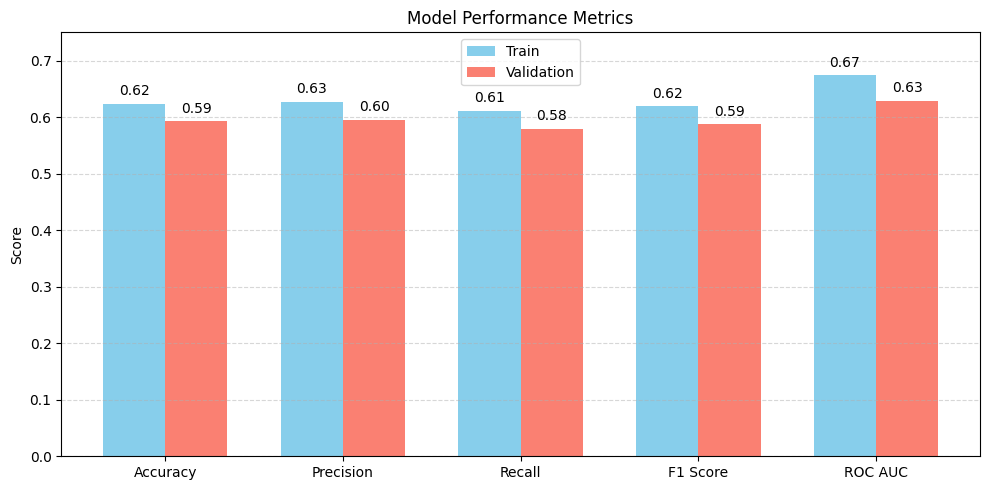

In [ ]:
#evaluation - plotting
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
train_values = [0.6236, 0.6267, 0.6114, 0.6189, 0.6739]
val_values   = [0.5928, 0.5954, 0.5793, 0.5872, 0.6285]

x = np.arange(len(metrics))  # Label locations
width = 0.35  # Width of the bars

plt.figure(figsize=(10, 5))
bars1 = plt.bar(x - width/2, train_values, width, label='Train', color='skyblue')
bars2 = plt.bar(x + width/2, val_values, width, label='Validation', color='salmon')

# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}', ha='center', va='bottom')

plt.ylabel('Score')
plt.title('Model Performance Metrics')
plt.xticks(x, metrics)
plt.ylim(0, 0.75)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
